In [1]:
# === Parsing des fichiers XML ===
from bs4 import BeautifulSoup

# === Préparation de données ===
import pandas as pd
import numpy as np

# === Visualisation ===
import matplotlib.pyplot as plt

# === Traitement de texte ===
import spacy
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

# === Classification et machine learning ===
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, Perceptron
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier

# === Évaluation des modèles ===
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

# === Autre ===
import prettytable
from prettytable.colortable import ColorTable, Themes
from itertools import product
import time

# Explications des données

On a installé sur le site du [DEFT 2009](https://deft.lisn.upsaclay.fr/) les données pour réaliser la tâche 3 qui est la suivante :
- entraîner un modèle qui détermine automatiquement le parti politique d’appartenance de chaque intervenant dans le corpus parlementaire.

Il y a en tout 5 classes qui correspondent aux différents partis politiques : 
| Classe (groupe)      | Orientation politique       | Thématiques principales                                   |
|--------------|-----------------------------|----------------------------------------------------------|
| **Verts-ALE** | Écologistes et régionalistes | Environnement, droits des minorités, économie durable    |
| **GUE/NGL**   | Gauche radicale             | Justice sociale, opposition à l'austérité, droits des travailleurs |
| **PSE**       | Social-démocrates           | Réduction des inégalités, protection sociale, intégration européenne |
| **ELDR**      | Libéraux                   | Libre marché, libertés individuelles, droits de l'homme  |
| **PPE-DE**    | Conservateurs              | Économie sociale de marché, valeurs chrétiennes, sécurité |


Notre corpus est multilingue, c'est-à-dire qu'il contient plusieurs langues différentes telles que le français, l'anglais et l'italien. C'est donc un corpus parallèle et comparable auquel nous avons affaire. 

# Extraction des données

Les données que nous avons téléchargé sur le site sont en format xml, il va donc nous falloir les parser pour les récolter. Pour cela, nous allons utilisé la librairie BeautifulSoup. Après avoir ouvert les fichiers et analysé les différentes balises pour pouvoir les extraire : texte, id, valeur (label) et confiance et nombre (demandez à K moi non plus je sais pas).

In [2]:
def get_xml_content(file):
    """ On se préparer à parser les fichiers xml"""
    with open(file, "r") as f:
        soup = BeautifulSoup(f, "xml")
        
    return soup

In [3]:
def extract_train_info(doc):
    """ On extrait les différentes balises"""
    doc_dico = {}

    # Extraire l'id
    doc_id = doc.get("id")
    doc_dico["id"] = doc_id

    # Extraire les label (ou valeur)
    parti = evaluation_parti.find("PARTI")
    doc_dico["valeur"] = parti.get("valeur")

   # Extraire le nombre et la confiance
    evaluation = doc.find("EVALUATION")
    evaluation_parti = evaluation.find("EVAL_PARTI")
    doc_dico["nombre"] = evaluation_parti.get("nombre")
    doc_dico["confiance"] = parti.get("confiance")

    # Extraire le texte
    texte = doc.find("p")
    doc_dico["texte"] = texte.text

    return doc_dico

In [4]:
def get_test_labels(file):
    
    with open(file, "r") as f:
        lines = f.readlines()

    lines = [line.split("\t") for line in lines]
    labels = {line[0]: line[1].strip() for line in lines}

    return labels

J'ai remarqué plus tard que deux textes de l'ensemble de test n'avaient pas de labels

In [5]:
labels = get_test_labels("data/ref/deft09_parlement_ref_fr.txt")
for key, value in labels.items():
    if value == "":
        print(key)

1175
4574


Je fais donc en sorte lorsque j'obtiens la df que si la valeur est égale à "" alors je ne prends pas le texte en compte.

In [6]:
def extract_test_info(doc):

    doc_dico = {}

    doc_id = doc.get("id")
    doc_dico["id"] = doc_id

    texte = doc.find("p")
    doc_dico["texte"] = texte.text

    return doc_dico

In [7]:
def get_train_and_test_df(train_file, test_file, ref_file):

    soup_train = get_xml_content(train_file)
    soup_test = get_xml_content(test_file)

    test_labels = get_test_labels(ref_file)

    all_docs = []
    for doc in soup_train.find_all("doc"):
        doc_dico = extract_train_info(doc)
        all_docs.append(doc_dico)
    
    df_train = pd.DataFrame(all_docs)

    all_docs = []
    for doc in soup_test.find_all("doc"):
        doc_dico = extract_test_info(doc)
        if test_labels[doc_dico["id"]] == "": # pour les deux textes sans label dans le fichier de référence
            continue
        doc_dico["valeur"] = test_labels[doc_dico["id"]]
        all_docs.append(doc_dico)

    df_test = pd.DataFrame(all_docs)
    
    return df_train, df_test

In [8]:
df_train, df_test = get_train_and_test_df("data/train/deft09_parlement_appr_fr.xml", "data/test/deft09_parlement_test_fr.xml", "data/ref/deft09_parlement_ref_fr.txt")

UnboundLocalError: cannot access local variable 'evaluation_parti' where it is not associated with a value

### Test pour la visu

In [51]:
def preparer_distributions_classes(df_train, df_test):
    """ Fonction pour préparer les données et pas les répéter 2 fois """
    train_counts = df_train["valeur"].value_counts()
    test_counts = df_test["valeur"].value_counts()

    ################################################
    #  changer valeur par label pour la cohérence  #
    ################################################

    classes = list(set(train_counts.index).union(set(test_counts.index)))

    # on met 0 si y'a pas de classe
    train_values = np.array([train_counts.get(cls, 0) for cls in classes])
    test_values = np.array([test_counts.get(cls, 0) for cls in classes])

    return classes, train_values, test_values

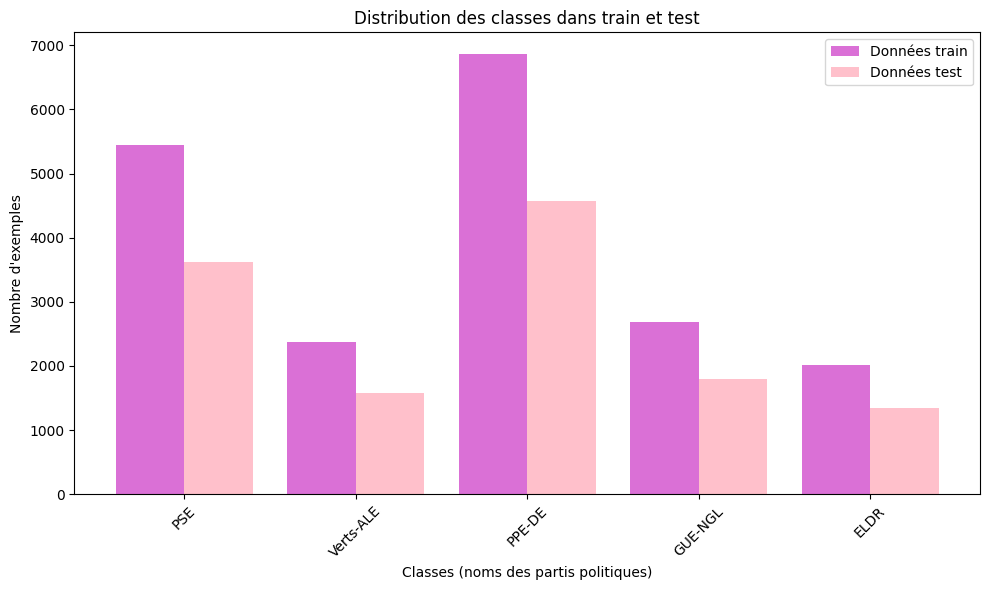

In [52]:
def distribution_des_classes(df_train, df_test):
    """ On affiche le plot des distributions des classes"""
    classes, train_values, test_values = preparer_distributions_classes(df_train, df_test)

    x = np.arange(len(classes))
    width = 0.40

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, train_values, width, label="Données train", color="orchid")
    ax.bar(x + width/2, test_values, width, label="Données test", color="pink")

    ax.set_xlabel("Classes (noms des partis politiques)")
    ax.set_ylabel("Nombre d'exemples")
    ax.set_title("Distribution des classes dans train et test")
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()

distribution_des_classes(df_train, df_test)

In [ ]:
prettytable_test_pourcentage = ColorTable(theme=Themes.LAVENDER)
prettytable_test_pourcentage.field_names = ["Classe", "Train", "Test", "Pourcentage"]

def tableau_test_pourcentage(df_train, df_test):
    classes, train_values, test_values = preparer_distributions_classes(df_train, df_test)

    # on met des 0 à la place des NaN pour éviter les divisions par zéro
    pourcentage_test = ((test_values / (test_values + train_values)) * 100)
    pourcentage_test = np.nan_to_num(pourcentage_test) 

    for cls, train, test, pourcentage in zip(classes, train_values, test_values, pourcentage_test):
        prettytable_test_pourcentage.add_row([cls, train, test, f"{pourcentage:.2f}%"])
    
    total_train = np.sum(train_values)
    total_test = np.sum(test_values)
    pourcentage_global = (total_test / (total_train + total_test)) * 100

    title = "Pourcentage de la part du test"
    print(f"{title}\n" + "=" * len(title))
    print(prettytable_test_pourcentage)
    print("\nRésumé des totaux\n" + "=" * len("Résumé des totaux"))
    print(f"Total Train : {total_train}")
    print(f"Total Test  : {total_test}")
    print(f"Pourcentage Global Test : {pourcentage_global:.2f}%")
    
tableau_test_pourcentage(df_train, df_test)

Pourcentage de la part du test
+-----------+-------+------+-------------+
|   Classe  | Train | Test | Pourcentage |
+-----------+-------+------+-------------+
|    PSE    |  5440 | 3627 |    40.00%   |
| Verts-ALE |  2376 | 1585 |    40.02%   |
|   PPE-DE  |  6858 | 4571 |    39.99%   |
|  GUE-NGL  |  2688 | 1793 |    40.01%   |
|    ELDR   |  2008 | 1339 |    40.01%   |
+-----------+-------+------+-------------+

Résumé des totaux
Total Train : 19370
Total Test  : 12915
Pourcentage Global Test : 40.00%


In [ ]:
df_train

,id,nombre,valeur,confiance,texte
0,2_fr:1,1,Verts-ALE,1.00,"Monsieur le Président, j'ai toujours fait preu..."
1,2_fr:2,1,PPE-DE,1.00,"Madame la Présidente, chers collègues, à l'app..."
2,2_fr:3,1,Verts-ALE,1.00,"Je voudrais savoir si l'Union européenne, à la..."
3,2_fr:4,1,PSE,1.00,"Madame la Présidente, au nom des de la commis..."
4,2_fr:5,1,PSE,1.00,"Monsieur le Président, chers collègues, Monsie..."
...,...,...,...,...,...
19365,2_fr:19366,1,PSE,1.00,"Monsieur le Président, je voudrais tout d’abor..."
19366,2_fr:19367,1,PPE-DE,1.00,"Monsieur le Président, Monsieur le Commissaire..."
19367,2_fr:19368,1,PPE-DE,1.00,"Monsieur le Président, je tiens à déclarer, au..."
19368,2_fr:19369,1,PPE-DE,1.00,"Monsieur le Président, l’aide à l’Albanie et à..."


In [ ]:
df_test

,id,texte,valeur
0,1,"Monsieur le Président, l'accès à des médias li...",ELDR
1,2,"Monsieur le Président, j'ai un point de vue di...",GUE-NGL
2,3,"Monsieur le Président, Monsieur le Commissaire...",PPE-DE
3,4,Nous ne pouvons soutenir cette tentative d’éri...,GUE-NGL
4,5,"Monsieur le Président, ce court débat se dérou...",PPE-DE
...,...,...,...
12910,12913,"Monsieur le Président, Madame la Commissaire, ...",PPE-DE
12911,12914,"Monsieur le Président, Monsieur le Commissaire...",PPE-DE
12912,12915,"Madame la Présidente, permettez-moi de m'adres...",ELDR
12913,12916,Grâce à la proposition de directive dont trait...,GUE-NGL


# Présentation des données

## Doublons

### Combien de doublons ?

In [56]:
train_texts = df_train["texte"].to_list()
test_texts = df_test["texte"].to_list()

In [57]:
def check_copy(train_texts, test_texts):

    num_copy = 0

    for text in train_texts:
        if text in test_texts:
            num_copy += 1

    return num_copy

In [ ]:
num_copy = check_copy(train_texts, test_texts)
print(f"Il y a {num_copy} textes en commun entre les données d'entraînement et de test.")

Il y a 7813 textes en commun entre les données d'entraînement et de test.


### On veut atteindre une distribution

Répartition des sets = 60 et 40

In [59]:
def get_distribution(df_train, df_test):

    total_texts = len(df_train) + len(df_test)
    percentage_train = len(df_train) / total_texts * 100
    percentage_test = len(df_test) / total_texts * 100

    return percentage_train, percentage_test

In [ ]:
percentage_train, percentage_test = get_distribution(df_train, df_test)
print(f"Pourcentage de textes d'entraînement : {percentage_train:.2f}%")
print(f"Pourcentage de textes de test : {percentage_test:.2f}%")

Pourcentage de textes d'entraînement : 60.00%
Pourcentage de textes de test : 40.00%


On veut enlever les doublons tout en essayant de conserver cette distribution.

In [61]:
def balance_distribution(df_train, df_test):

    train_texts = df_train["texte"].to_list()
    test_texts = df_test["texte"].to_list()

    for text in train_texts:
        if text in test_texts:
            percentage_train, percentage_test = get_distribution(df_train, df_test)
            difference_train = abs(percentage_train - 60)
            difference_test = abs(percentage_test - 40)

            if difference_train > difference_test:
                df_test = df_test[df_test["texte"] != text]
            else:
                df_train = df_train[df_train["texte"] != text]

    return df_train, df_test

In [ ]:
df_train, df_test = balance_distribution(df_train, df_test)
percentage_train, percentage_test = get_distribution(df_train, df_test)
print(f"Pourcentage de textes d'entraînement : {percentage_train:.2f}%")
print(f"Pourcentage de textes de test : {percentage_test:.2f}%")

Pourcentage de textes d'entraînement : 53.40%
Pourcentage de textes de test : 46.60%


In [ ]:
train_texts = df_train["texte"].to_list()
test_texts = df_test["texte"].to_list()
num_copy = check_copy(train_texts, test_texts)
print(f"Il y a {num_copy} textes en commun entre les données d'entraînement et de test.")

Il y a 0 textes en commun entre les données d'entraînement et de test.


### Retirer jusqu'à 60

Nous n'avons plus de doublons mais nous restons quelque peu éloignés de la distribution 60/40. On va donc retirer des textes de l'ensemble de test pour arriver à la distribution souhaitée.

In [64]:
def reach_desired_distribution(df_train, df_test):

    while True:
        percentage_train, percentage_test = get_distribution(df_train, df_test)

        if percentage_train >= 60:
            break
        else:
            df_test = df_test.drop(df_test.index[0])

    
    return df_train, df_test

In [ ]:
df_train, df_test = reach_desired_distribution(df_train, df_test)
percentage_train, percentage_test = get_distribution(df_train, df_test)
print(f"Pourcentage de textes d'entraînement : {percentage_train:.2f}%")
print(f"Pourcentage de textes de test : {percentage_test:.2f}%")
num_copy = check_copy(train_texts, test_texts)
print(f"Il y a {num_copy} textes en commun entre les données d'entraînement et de test.")

Pourcentage de textes d'entraînement : 60.00%
Pourcentage de textes de test : 40.00%
Il y a 0 textes en commun entre les données d'entraînement et de test.


In [66]:
df_train.to_csv("data/train.csv", index=False)
df_test.to_csv("data/test.csv", index=False)

## Visualisation des données

Est-ce que les classes sont représentées de manière égale entre les deux ensembles ?

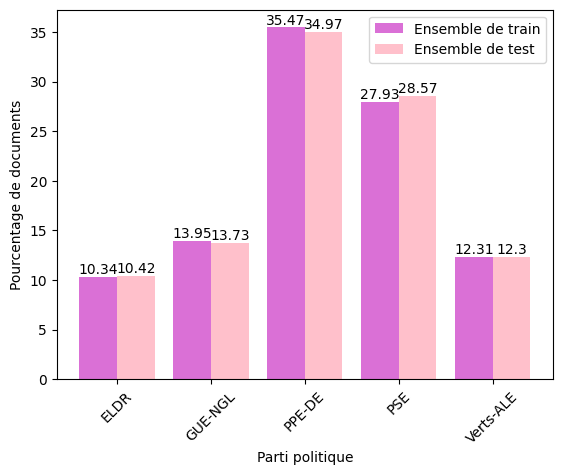

In [67]:
def compare_class_distribution(df_train, df_test):

    total_train = len(df_train)
    total_test = len(df_test)

    train_distribution = {source: count / total_train * 100 for source, count in df_train.groupby("valeur").size().to_dict().items()}
    test_distribution = {source: count / total_test * 100 for source, count in df_test.groupby("valeur").size().to_dict().items()}

    x = np.arange(len(train_distribution))
    width = 0.4
    train_bars = plt.bar(x - 0.2, train_distribution.values(), width, label="Ensemble de train", color="orchid")
    test_bars = plt.bar(x + 0.2, test_distribution.values(), width, label="Ensemble de test", color="pink")

    for bar in train_bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{round(height, 2)}', ha='center', va='bottom')

    for bar in test_bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{round(height, 2)}', ha='center', va='bottom')

    plt.xticks(x, train_distribution.keys(), rotation=45)
    plt.xlabel("Parti politique")
    plt.ylabel("Pourcentage de documents")
    plt.legend()
    plt.show()

compare_class_distribution(df_train, df_test)


Les répartitions sont assez égalitaires ! 


||   ELDR    | GUE/NGL | PPE-DE     | PSE | Verts/ALE
|:---| :---        |    :----   |          :--- | :--- | :--- |
|Nombre de documents| 3 346 | 4 482   |  11 429 | 9 066 | 3 961 |
|Pourcentage de documents|10.33%|13.84%|35.29%|27.99%|12.23%|

On a donc un corpus sans doublons mais avec une répartition et une distribution des classes et des documents fidèle au corpus originel !

# Pé-traitement des données

## Normalisation

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 7.0 MB/s eta 0:00:00m eta 0:00:010:01:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [69]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
nlp = spacy.load("en_core_web_sm")

In [70]:
def lemmatisation(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [71]:
def i_love_lowercase(text):

    return text.lower()

In [72]:
def remove_stop_words(text):
    
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]

    return " ".join(filtered_text)

In [73]:
def remove_punctuation(text):

    text = re.sub(r"[^\w\s]", "", text)
    
    return text

In [ ]:
def get_beautiful_clean_text(text):

    text = i_love_lowercase(text)
    text = remove_punctuation(text)
    text = remove_stop_words(text)
    text = lemmatisation(text)

    return text

df_train["texte_nettoyé"] = df_train["texte"].map(get_beautiful_clean_text)
df_test["texte_nettoyé"] = df_test["texte"].map(get_beautiful_clean_text)

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/home/debora/nltk_data'
    - '/home/debora/Documents/scripts/.venv/deft09/nltk_data'
    - '/home/debora/Documents/scripts/.venv/deft09/share/nltk_data'
    - '/home/debora/Documents/scripts/.venv/deft09/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [92]:
df_train.to_csv("data/train.csv", index=False)
df_test.to_csv("data/test.csv", index=False)


In [3]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [4]:
df_train.head()

,id,nombre,valeur,confiance,texte,texte_nettoyé
0,2_fr:2,1,PPE-DE,1.0,"Madame la Présidente, chers collègues, à l'app...",madame la présidente cher collègue à lapproche...
1,2_fr:5,1,PSE,1.0,"Monsieur le Président, chers collègues, Monsie...",monsieur le président cher collègue monsieur l...
2,2_fr:6,1,Verts-ALE,1.0,"C'est une motion de procédure, la question 67 ...",cest une motion de procédure la question 67 de...
3,2_fr:7,1,PPE-DE,1.0,"Monsieur le Président, nous sommes favorables ...",monsieur le président nous somme favorable à c...
4,2_fr:9,1,PSE,1.0,"Madame la Présidente, je ne vois rien de discr...",madame la présidente je ne vois rien de discri...


## Vectorisation

Dans l'article, on voit que les paramètres de la vectorisation jouent un rôle assez important.
Nous allons donc essayer de tester cela avec le tfidf et le count vectorizer sur le KNN, l'algorithme utilisé dans l'article. 
Nous allons vectorisser de manière différentes nos données et stocker le tout dans une df assez grande. Nous allons ensuite tester le tout sur le KNN pour voir comment cela impacte nos données et jusqu'où on peut aller !

## Organisation

In [6]:
vectorizers = {
    "TfidfVectorizer": {
        "model": TfidfVectorizer(),
        "hyperparameters": {
            "max_df": [0.5, 0.9, 1], # ça c'est pour ignorer les mots qui appraîssent dans 0.5 ou 0.9 des documents #defaut = 1
            "max_features": [1000, 5000, 10000, 15000], # ça c'est pour limiter le nombre de mots à 1000 ou 2000 #defaut = None
            "ngram_range": [(1, 1), (1, 2)], # ça c'est pour prendre en compte les unigrammes ou les bigrammes #defaut = (1, 1)
        }
    },
    "CountVectorizer": {
        "model": CountVectorizer(),
        "hyperparameters": {
            "max_df": [0.8, 0.9],
            "max_features": [1000, 5000, 10000, 15000],
            "ngram_range": [(1, 1), (1, 2)],
        }
    }
}

In [7]:
def hyperparameter_vectorizer(vectorizers):

    param_grid = vectorizers["hyperparameters"]
    list_vectorizers = []


    if len(param_grid) == 1:
        param_name, param_values = list(param_grid.items())[0]
        for i, value in enumerate(param_values, start=1):
            params = {param_name: value}
            vectorizer = vectorizers["model"].__class__(**params) 
            list_vectorizers.append(vectorizer)

    else:
        param_grid_combinations = list(product(*param_grid.values()))
        for i, combination in enumerate(param_grid_combinations, start=1):
            params = {param_name: value for param_name, value in zip(param_grid.keys(), combination)}
            vectorizer = vectorizers["model"].__class__(**params) 
            list_vectorizers.append(vectorizer)

    return list_vectorizers

In [8]:
list_vectorizers = hyperparameter_vectorizer(vectorizers["TfidfVectorizer"])
list_vectorizers

[TfidfVectorizer(max_df=0.5, max_features=1000),
 TfidfVectorizer(max_df=0.5, max_features=1000, ngram_range=(1, 2)),
 TfidfVectorizer(max_df=0.5, max_features=5000),
 TfidfVectorizer(max_df=0.5, max_features=5000, ngram_range=(1, 2)),
 TfidfVectorizer(max_df=0.5, max_features=10000),
 TfidfVectorizer(max_df=0.5, max_features=10000, ngram_range=(1, 2)),
 TfidfVectorizer(max_df=0.5, max_features=15000),
 TfidfVectorizer(max_df=0.5, max_features=15000, ngram_range=(1, 2)),
 TfidfVectorizer(max_df=0.9, max_features=1000),
 TfidfVectorizer(max_df=0.9, max_features=1000, ngram_range=(1, 2)),
 TfidfVectorizer(max_df=0.9, max_features=5000),
 TfidfVectorizer(max_df=0.9, max_features=5000, ngram_range=(1, 2)),
 TfidfVectorizer(max_df=0.9, max_features=10000),
 TfidfVectorizer(max_df=0.9, max_features=10000, ngram_range=(1, 2)),
 TfidfVectorizer(max_df=0.9, max_features=15000),
 TfidfVectorizer(max_df=0.9, max_features=15000, ngram_range=(1, 2)),
 TfidfVectorizer(max_df=1, max_features=1000),
 

## Vectorisation des données

In [9]:
def store_vectorisations(list_vectorizers, x_train, x_test):

    all_vectorisations = []

    for i, vectorizer in enumerate(list_vectorizers):
        x_train_vectorized = vectorizer.fit_transform(x_train)
        x_test_vectorized = vectorizer.transform(x_test)
        all_vectorisations.append({"vectorizer_id": vectorizer.__class__.__name__ + str(i),
                                   "vectorizer": vectorizer, 
                                   "x_train": x_train_vectorized, 
                                   "x_test": x_test_vectorized})
    
    df_vectorisations = pd.DataFrame(all_vectorisations)

    return df_vectorisations

In [10]:
df_vectorisations = store_vectorisations(list_vectorizers, df_train["texte_nettoyé"], df_test["texte_nettoyé"])

## Test avec KNN

In [11]:
def im_counting_on_you_knn(df_vectorisations, y_train, y_test):

    model = KNeighborsClassifier(n_neighbors=1)
    scores = []

    for i, row in df_vectorisations.iterrows():
        vectorizer = row["vectorizer"]
        x_train = row["x_train"]
        x_test = row["x_test"]
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        scores.append({"vectorizer": vectorizer, "scores": report})
                      
    return scores


In [12]:
scores = im_counting_on_you_knn(df_vectorisations, df_train["valeur"], df_test["valeur"])

In [15]:
sorted_scores = sorted(scores, key=lambda x: x["scores"]["accuracy"], reverse=True)

In [16]:
for score in sorted_scores:
    print(f"Vectorizer: {score['vectorizer'].__class__.__name__}")
    for key, value in score["scores"].items():
        print(f"\t{key}: {value}")

Vectorizer: TfidfVectorizer
	ELDR: {'precision': 0.18181818181818182, 'recall': 0.006607929515418502, 'f1-score': 0.012752391073326248, 'support': 908.0}
	GUE-NGL: {'precision': 0.13793103448275862, 'recall': 0.0033444816053511705, 'f1-score': 0.006530612244897959, 'support': 1196.0}
	PPE-DE: {'precision': 0.3506981109937815, 'recall': 0.9809648834919593, 'f1-score': 0.5166810717372515, 'support': 3047.0}
	PSE: {'precision': 0.3382352941176471, 'recall': 0.009240658899156288, 'f1-score': 0.01798983183418068, 'support': 2489.0}
	Verts-ALE: {'precision': 0.0847457627118644, 'recall': 0.0046641791044776115, 'f1-score': 0.008841732979664015, 'support': 1072.0}
	accuracy: 0.3474517906336088
	macro avg: {'precision': 0.2186856768248467, 'recall': 0.20096442652327262, 'f1-score': 0.1125591279738641, 'support': 8712.0}
	weighted avg: {'precision': 0.2676020058788204, 'recall': 0.3474517906336088, 'f1-score': 0.18916116139949027, 'support': 8712.0}
Vectorizer: TfidfVectorizer
	ELDR: {'precision

Résultats médiocres et le model avec la meilleure accuracy a des fscores désastreuses. PLutôt utiliser ces dernières pour l'évaluation.

# Comparaison

In [17]:
def time_function(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        return result, end - start
    return wrapper

In [18]:
class Model:

    # Contient tous les modèles entrainés ! 
    all_models = []

    def __init__(self, name: str, model=None, vectorisation=None, scores={}, running_time=None, performance=None):
        self.name = name
        self.model = model
        self.vectorisation = vectorisation
        self.scores = scores
        self.running_time = running_time
        self.performance = performance

        Model.all_models.append(self)
        # Pour chaque modèle entraîné, on garde son nom (algo + num), le modèle et ses 
        # hyperparamètres pour cet entraînement, les métriques obtenues, et son temps d'execution !

    # Pour vider la liste si nécessaire ! 
    @classmethod
    def reset(cls):
        cls.all_models = []

    # Entraîne le modèle
    @time_function
    def fit_model(self, x_train, y_train):
        self.model.fit(x_train, y_train)
    
    # Prédictions et scores
    @time_function
    def predict(self, x_test, y_test):
        y_pred = self.model.predict(x_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_dict =  {"accuracy": accuracy, **report}
        self.scores = accuracy_dict
        return y_pred

      # Lance les fonctions d'entraînement et de prédiction
    # Stock les temps d'execution
    def test_model(self, x_train, y_train, x_test, y_test):
        _, fit_execution_time = self.fit_model(x_train, y_train)
        y_pred, predict_execution_time = self.predict(x_test, y_test)
        self.running_time = fit_execution_time + predict_execution_time

In [19]:
Model.reset()

In [25]:
models_dict = {
    "LogisticRegression": {"model": LogisticRegression(), "hyperparameters": {"C": [0.5, 1.0]}},
    # "SGDClassifier": {"model": SGDClassifier(), "hyperparameters": {"alpha": [0.0001, 0.001, 0.01], "loss": ["hinge", "squared_hinge"]}},
    "LinearSVC": {"model": LinearSVC(), "hyperparameters": {"C": [0.5, 1.0], "dual":[True, False]}},
    # "SVC": {"model": SVC(), "hyperparameters": {"kernel": ["poly", "sigmoid"]}},
    "RidgeClassifier": {"model": RidgeClassifier(), "hyperparameters": { "alpha": [1.0, 1.5, 2]}},
    "LGBMClassifier": {"model": LGBMClassifier(), "hyperparameters": {"max_depth": [1000], "n_estimators": [1000]}},
    "RandomForestClassifier": {"model": RandomForestClassifier(), "hyperparameters": {"max_depth": [100]}}
 }

In [21]:
def hyperparameters_training(model_name, model_dict, x_train, y_train, x_test, y_test):
    param_grid = model_dict["hyperparameters"]

    if len(param_grid) == 1:
        param_name, param_values = list(param_grid.items())[0]
        for i, value in enumerate(param_values, start=1):
            params = {param_name: value}
            model = model_dict["model"].__class__(**params)  
            model_obj = Model(name=f"{model_name}_{i}", model=model)
            model_obj.test_model(x_train, y_train, x_test, y_test)
    else:
        param_grid_combinations = list(product(*param_grid.values()))
        for i, combination in enumerate(param_grid_combinations, start=1):
            params = {param_name: value for param_name, value in zip(param_grid.keys(), combination)}
            model = model_dict["model"].__class__(**params) 
            model_obj = Model(name=f"{model_name}_{i}", model=model)
            model_obj.test_model(x_train, y_train, x_test, y_test)

In [22]:
@time_function
def test_models(models, x_train, y_train, x_test, y_test):
                                 
    for model_name, model_dict in models.items():
        print(f"On teste le modèle {model_name} !")
        hyperparameters_training(model_name, model_dict, x_train, y_train, x_test, y_test)

In [26]:
def test_models_and_vectorisations(models, vectorisations, df_train, df_test):
    
    for i, row in vectorisations.iterrows():
        print(f"Vectorisation {row['vectorizer'].__class__.__name__} en cours !")
        x_train = row["x_train"]
        x_test = row["x_test"]
        test_models(models, x_train, df_train["valeur"], x_test, df_test["valeur"])

In [183]:
test_models_and_vectorisations(models_dict, df_vectorisations, df_train, df_test)

NameError: name 'test_models_and_vectorisations' is not defined

In [75]:
##### POUR VISUALISER TOUS LES RÉSULTADOS ! #####
def table_results(models):

    bests_of_the_bests = PrettyTable(["Model", "hyperparametres", "Accuracy", "Precision", "Recall", "F1-Score", "Running Time"], theme=Themes.LAVENDER)
    bests_of_the_bests = ColorTable(theme=Themes.LAVENDER)
    
    for model_obj in models:
        if "accuracy" in model_obj.scores.keys():
            bests_of_the_bests.add_row([model_obj.name, model_obj.model, model_obj.scores["accuracy"], model_obj.scores["macro avg"]["precision"], model_obj.scores["macro avg"]["recall"], model_obj.scores["macro avg"]["f1-score"], model_obj.running_time])

    return bests_of_the_bests

table_results(Model.all_models)

NameError: name 'Model' is not defined